In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
import skimage 


batch_size = 50
num_classes = 10
epochs = 2

saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train_noisy, y_train_noisy), (x_test_noisy, y_test_noisy) = cifar10.load_data()

def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_val = x_test[:7000]
x_test = x_test[7000:]

print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

tensorflow


Using TensorFlow backend.


validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


In [3]:
def gaussian(image):
    num,row,col,ch= image.shape
    #print(image[1].shape)
    mean = 0
    var = 0.2
    sigma = var**0.5
    
    gauss = np.random.normal(mean,sigma,(num,row,col,ch))
    gauss.astype("float32")
    gauss = gauss.reshape(num,row,col,ch)
    #gauss=gauss.astype('uint8')
    y=image+0.2*gauss


    #noisy = image+gauss
    y= np.clip(y, 0, 255)
    #noisy = noisy.astype('uint8')
    #y=y.astype('uint8')
    return y

def s_p(image):
    num,row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.006
    out = np.copy(image)
          # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
           for i in image.shape]

    out[coords] = 1

          # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
    out[coords] = 0


    #noisy = image+gauss
    y = np.clip(out, 0, 255)
    #noisy = noisy.astype('uint8')
    return y
    #image=image.astype('uint8')
    
def speckle(image):
    num,row,col,ch = image.shape
    gauss = np.random.randn(num,row,col,ch)
    gauss.astype("float32")
    gauss = gauss.reshape(num,row,col,ch)        
    noisy = image + image * gauss*0.1
    y = np.clip(noisy, 0, 255)
    return y

In [4]:
t1, t2, t3= x_train[:16667],x_train[16667:33334],x_train[33334:]
s1, s2, s3= x_test[:1000],x_test[1000:2000],x_test[2000:]
v1, v2, v3= x_val[:2333],x_val[2333:4667],x_val[4667:]

t1=gaussian(t1)
t2=s_p(t2)
t3=speckle(t3)
s1=gaussian(s1)
s2=s_p(s2)
s3=speckle(s3)
v1=gaussian(v1)
v2=s_p(v2)
v3=speckle(v3)


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [4]:
showOrigDec(x_train, t2)

<Figure size 2000x400 with 20 Axes>

In [5]:
# add gaussian noise

#noise_factor = 0.2
#gaussian noise
#t1 = t1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=t1.shape) 
#s1 = s1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s1.shape)
#v1 = v1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=v1.shape)

#noise_factor = 0.1
#t2 = t2 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=t2.shape) 
#s2 = s2 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s2.shape)
#v2 = v2 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=v2.shape)
#noise_factor = 0.2
#t3 = t3 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=t3.shape) 
#s3 = s3 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s3.shape)
#v3 = v3 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=v3.shape)
#noise_factor = 0.3
#t4 = t4 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=t4.shape) 
#s4 = s4 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s4.shape)
#v4 = v4 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=v4.shape)
#add s&p noise

t1=np.clip(t1, 0., 1.)
t2=np.clip(t2, 0., 1.)
t3=np.clip(t3, 0., 1.)
#t4=np.clip(t4, 0., 1.)
s1=np.clip(s1, 0., 1.)
s2=np.clip(s2, 0., 1.)
s3=np.clip(s3, 0., 1.)
#s4=np.clip(s4, 0., 1.)
v1=np.clip(v1, 0., 1.)
v2=np.clip(v2, 0., 1.)
v3=np.clip(v3, 0., 1.)
#v4=np.clip(v4, 0., 1.)

x_train_noisy=np.concatenate([t1,t2,t3])
x_test_noisy=np.concatenate([s1,s2,s3])
x_val_noisy=np.concatenate([v1,v2,v3])

In [6]:
print(x_train_noisy.shape)
print(x_test_noisy.shape)
print(x_val_noisy.shape)
# np.random.shuffle(x_train_noisy)
#training_data=[]
#for x in range(len(x_train_noisy)):
#    try:
#        training_data.append([x_train_noisy,x_train])
#    except Exception as e :
#        pass
#import random
#random.shuffle(training_data)

#x_train_noisy, x_train = training_data

#noise_factor = 0.2
#x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
#x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
#x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#x_val_noisy = np.clip(x_val_noisy, 0., 1.)

showOrigDec(x_train, x_train_noisy)

(50000, 32, 32, 3)
(3000, 32, 32, 3)
(7000, 32, 32, 3)


<Figure size 2000x400 with 20 Axes>

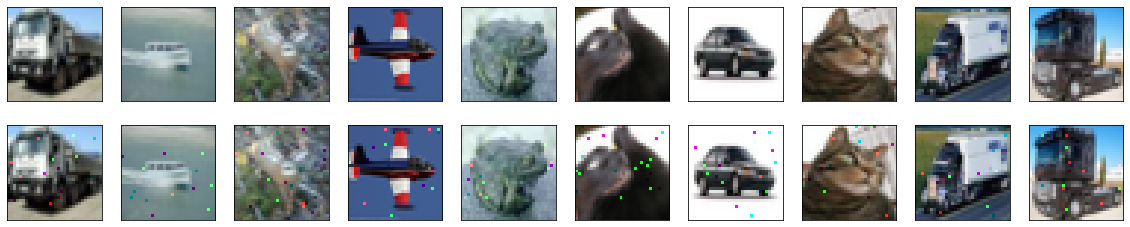

In [7]:
showOrigDec(x_train[25001:], x_train_noisy[25001:])

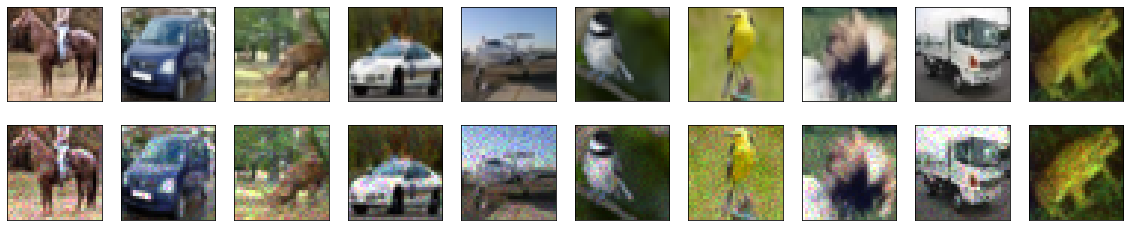

In [8]:
showOrigDec(x_train[45000:], x_train_noisy[45000:])

In [9]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_val_noisy, x_val),
                    #callbacks=[es_cb, cp_cb],
                    shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 7000 samples
Epoch 1/20
50000/50000 [==============================] - 1160s 23ms/step - loss: 0.5666 - val_loss: 0.5608
Epoch 2/20
50000/50000 [==============================] - 1137s 23ms/step - loss: 0.5588 - val_loss: 0.5577
Epoch 3/20
50000/50000 [==============================] - 1129s 23ms/step - loss: 0.5570 - val_loss: 0.5570
Epoch 4/20
50000/50000 [==============================] - 1130s 23ms/step - loss: 0.5561 - val_loss: 0.5561
Epoch 5/20
50000/50000 [==============================] - 1105s 22ms/step - loss: 0.5556 - val_loss: 0.5554
Epoch 6/20
50000/50000 [==============================] - 1124s 22ms/step - loss: 0.5552 - val_loss: 0.5564
Epoch 7/20
50000/50000 [==============================] - 1112s 22ms/step - loss: 0.5548 - val_loss: 0.5555
Epoch 8/20
50000/50000 [==============================] - 1107s 22ms/step - loss: 0.5546 - val_loss: 0.5557
Epoch 9/20
50000/50000 [===============

In [12]:
score = model.evaluate(x_test_noisy, x_test, verbose=1)
print(score)
model.save('denoise_autoencoder.h5')

3000/3000 [==============================] - 13s 4ms/step
0.5535612858136495


In [13]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [16]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))


Cifar10_test: 0.4744892120361328
Cifar10_val: 0.47775164246559143


In [14]:
print(type(c10test[0][0][0,0]))
print(type(x_test[0][0][0,0]))
x_test_noisy=x_test_noisy.astype('float32')
print(type(x_test_noisy[0][0][0,0]))


<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>


In [15]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [16]:
from skimage.measure import compare_ssim as ssim
def cal_ssim(orig, noise, denoise):
    val1=0
    val2=0
    for i in range(len(orig)):
        val1+=ssim(orig,denoise,multichannel=True)
        val2+=ssim(orig,noise,multichannel=True)
    val1/=len(orig)
    val2/=len(orig)
    
    return val1, val2
    

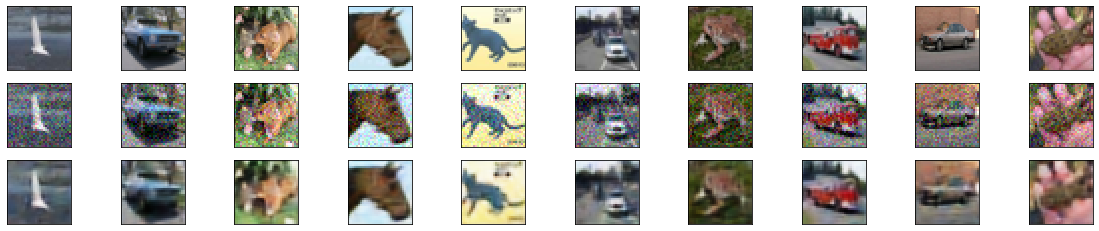

In [17]:
showOrigDec(x_test, x_test_noisy, c10test)

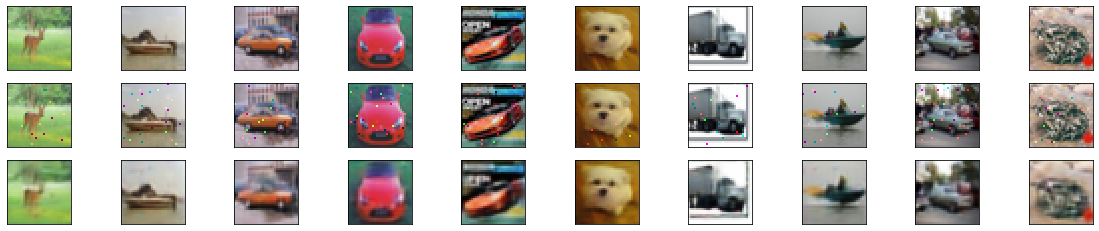

In [18]:
showOrigDec(x_test[1500:], x_test_noisy[1500:], c10test[1500:])

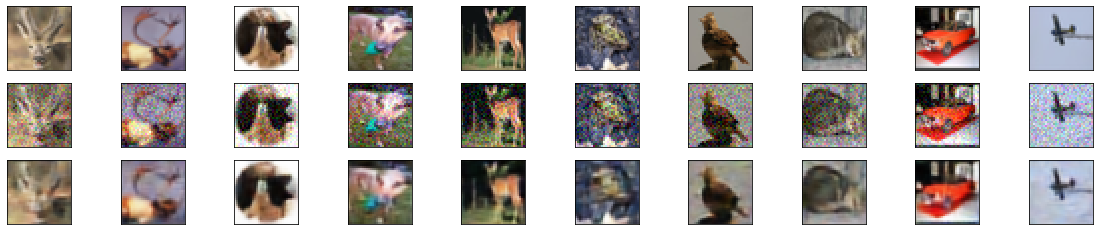

In [19]:
showOrigDec(x_test[200:], x_test_noisy[200:], c10test[200:])

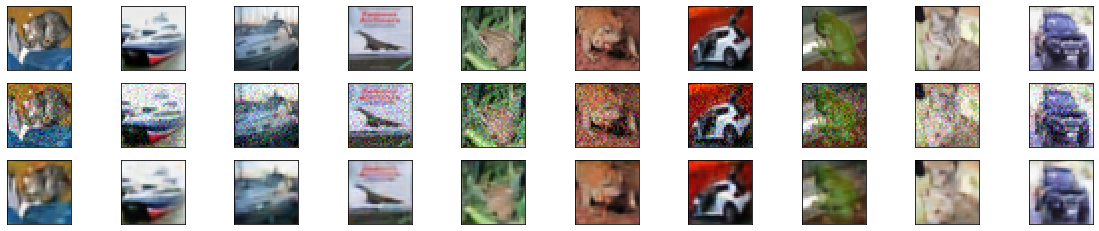

In [20]:
showOrigDec(x_val, x_val_noisy, c10val)

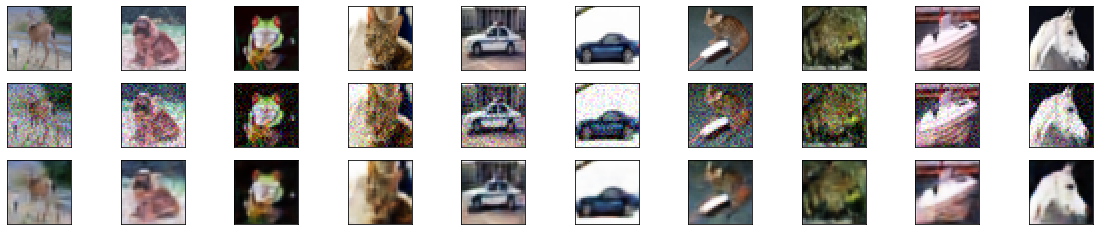

In [21]:
showOrigDec(x_val[100:], x_val_noisy[100:], c10val[100:])

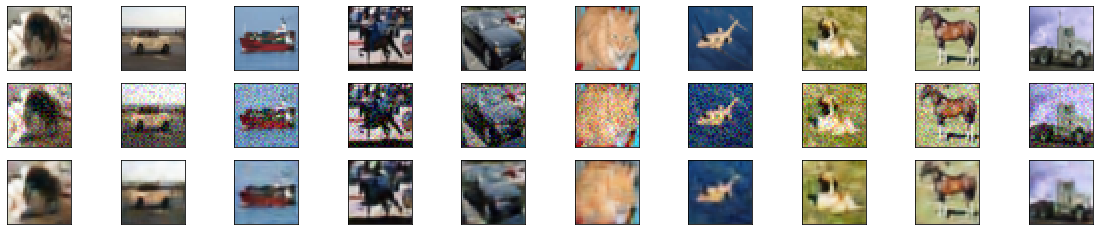

In [22]:
showOrigDec(x_val[200:], x_val_noisy[200:], c10val[200:])

In [ ]:
ssim1, ssim2= cal_ssim(x_test[:10], x_test_noisy[:10], c10test[:10])
print("Gaussian : ssim between original and denoised image = "+str(ssim1)+" between original and noisy image= "+str(ssim2))
ssim1, ssim2= cal_ssim(x_test[1000:1010], x_test_noisy[1000:1010], c10test[1000:1010])
print("Salt and pepper : ssim between original and denoised image = "+str(ssim1)+" between original and noisy image= "+str(ssim2))
ssim1, ssim2= cal_ssim(x_test[2000:2010], x_test_noisy[2000:2010], c10test[2000:2010])
print("Speckle" : ssim between original and denoised image = "+str(ssim1)+" between original and noisy image= "+str(ssim2))